# Lugar ideal (nome da aplicação TBD)

Aplicação que utiliza algoritmos não-supervisionados de agrupamento para sugerir moradias de melhor custo-benefício de acordo com preferências do usuário. 


Obs: O parâmetro Custo-beneficio é definido como a razão entre área do imóvel e preço do aluguel. 

Para uma versão futura, uma definição do custo beneficio mais apurada deverá incluir não somente as informações dadas pelo usuário, como também o nível de importância (ou peso) de cada uma das preferências.  


In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

sns.set_theme(style="whitegrid")


## 1. Data cleaning

Nessa parte vamos:

1. criar um unico pandas data frame com todos os dados raspados do site quinto andar
2. criar uma coluna para assinalar o bairro
3. criar uma coluna para assinalar o score (incialmente tido como razão preço/area)

In [23]:
# Pasta onde o banco de dados esta salvo
folder = r"D:\Tech-Challenge-QuintoAndar\database\data"

# Lista todos os arquivos csv na pasta do banco de dados
files = [f for f in os.listdir(folder) if f.endswith(".csv")]

# concatenando dados em um unico data set
dfs = []
for f in files:
    path = os.path.join(folder, f)
    df = pd.read_csv(path)
    # Adicionando uma coluna com o bairro
    neighborhood = os.path.splitext(f)[0].replace("quintoandar_", "")
    df["neighborhood"] = neighborhood.split('_')[0]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

print("Merged shape:", data.shape)
data.head()

Merged shape: (2145, 20)


,url,status,title,address_street,area,quartos,suite,banheiros,vagas,andar,pet,mobiliado,metro_proximo,Aluguel,Condomínio,IPTU,Seguro incêndio,Taxa de serviço,Total,neighborhood
0,https://www.quintoandar.com.br/imovel/89496410...,success,"Studio para alugar com 25m², 1 quarto e sem vaga",Rua Eleutério,25.0,1.0,1,1.0,NaN,20° a 23° andar,não,sim,sim,R$ 3.500,R$ 550,R$ 0,R$ 45,R$ 90,R$ 4.185,brooklin
1,https://www.quintoandar.com.br/imovel/89460040...,success,"Apartamento para alugar com 116m², 3 quartos e...",Condomínios em São Paulo,116.0,3.0,2,3.0,2.0,Até 3° andar,sim,sim,sim,R$ 10.000,R$ 1.300,R$ 0,R$ 127,R$ 259,R$ 11.686,brooklin
2,https://www.quintoandar.com.br/imovel/89499927...,success,"Apartamento para alugar com 28m², 1 quarto e s...",Avenida Santo Amaro,28.0,1.0,1,1.0,NaN,8° a 11° andar,não,sim,sim,R$ 2.950,R$ 760,R$ 0,R$ 38,R$ 76,R$ 3.824,brooklin
3,https://www.quintoandar.com.br/imovel/89506631...,success,"Studio para alugar com 26m², 1 quarto e sem vaga",Rua Eleutério,26.0,1.0,0,1.0,NaN,8° a 11° andar,sim,não,sim,R$ 2.700,R$ 550,R$ 1,R$ 35,R$ 69,R$ 3.355,brooklin
4,https://www.quintoandar.com.br/imovel/89495522...,success,"Studio para alugar com 32m², 1 quarto e 1 vaga",Avenida Portugal,32.0,1.0,0,1.0,1.0,16° a 19° andar,não,sim,sim,R$ 3.680,R$ 600,R$ 100,R$ 47,R$ 95,R$ 4.522,brooklin


Abaixo vemos o número de entradas não-numéricas (NaN) no data frame. Ocorrências desse tipo foram tratadas da seguinte forma:

* Colunas 'endereço', 'andar', 'Seguro incêndio', 'Status', 'Taxa de serviço' e 'url' são desconsideradas da análise, portando entradas nan nessas colunas são irrelevantes 
* Entradas NaN na coluna 'quarto' serão substituídas por 1 (studios)
* Entradas NaN na coluna 'vaga' serão substituídas por 0 (sem vaga)
* Linhas com entradas NaN na coluna 'area' e 'banheiro' serão excluídas



In [24]:
# Count NaNs per column
print(data.isna().sum())

url                   0
status                0
title                 0
address_street       36
area                  2
quartos              14
suite                 0
banheiros             2
vagas              1086
andar               337
pet                   0
mobiliado             0
metro_proximo         0
Aluguel               0
Condomínio            0
IPTU                  0
Seguro incêndio       2
Taxa de serviço       2
Total                 0
neighborhood          0
dtype: int64


In [25]:
# criando copia do data frame original para nao altera-lo
data_refined = data.copy() 

# descartar as colunas abaixo
cols_to_drop = ["url", "status", "title", "address_street", "andar"]
data_refined = data_refined.drop(columns=cols_to_drop, errors="ignore")

print(data_refined.isna().sum())

# data_refined.head()

area                  2
quartos              14
suite                 0
banheiros             2
vagas              1086
pet                   0
mobiliado             0
metro_proximo         0
Aluguel               0
Condomínio            0
IPTU                  0
Seguro incêndio       2
Taxa de serviço       2
Total                 0
neighborhood          0
dtype: int64


In [26]:
# Converte 'sim' / 'não' para 1 / 0 nas colunas abaixo
bool_cols = ["pet", "mobiliado", "metro_proximo"]

for col in bool_cols:
    data_refined[col] = data_refined[col].astype(str).str.strip().str.lower()
    data_refined[col] = data_refined[col].replace({"sim": 1, "não": 0, "nao": 0})
    data_refined[col] = data_refined[col].astype(int)

# converte nan em 1/0 na coluna 'quarto'/'vaga' 
data_refined['quartos'] = data_refined['quartos'].replace(np.nan, 1) 
data_refined['vagas'] = data_refined['vagas'].replace(np.nan, 0) 

# Remove R$ das colunas de preço e acerta os valores 
price_cols = ["Aluguel", "Condomínio", "Seguro incêndio", "Total", "IPTU", "Taxa de serviço"]  

for col in price_cols:
    data_refined[col] = (
        data_refined[col]
        .astype(str)
        .str.replace("R$", "", regex=False)
        .str.replace(".", "", regex=False)  
        .str.replace(",", ".", regex=False)  
        .str.strip()
    )
    data_refined[col] = pd.to_numeric(data_refined[col], errors="coerce")
print(data_refined.isna().sum())


area                 2
quartos              0
suite                0
banheiros            2
vagas                0
pet                  0
mobiliado            0
metro_proximo        0
Aluguel              0
Condomínio         334
IPTU                 0
Seguro incêndio      2
Taxa de serviço      2
Total                0
neighborhood         0
dtype: int64


C:\Users\josea\AppData\Local\Temp\ipykernel_16852\3951678103.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_refined[col] = data_refined[col].replace({"sim": 1, "não": 0, "nao": 0})
C:\Users\josea\AppData\Local\Temp\ipykernel_16852\3951678103.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_refined[col] = data_refined[col].replace({"sim": 1, "não": 0, "nao": 0})
C:\Users\josea\AppData\Local\Temp\ipykernel_16852\3951678103.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a

In [27]:
# agora, finalmente, dropando as linhas com as últimas 
# entradas nan nas colunas area e banheiros
# e criando a coluna score
data_refined = data_refined.dropna()

data_refined['score'] = data_refined['Total'] / data_refined['area']

print(data_refined.isna().sum())


area               0
quartos            0
suite              0
banheiros          0
vagas              0
pet                0
mobiliado          0
metro_proximo      0
Aluguel            0
Condomínio         0
IPTU               0
Seguro incêndio    0
Taxa de serviço    0
Total              0
neighborhood       0
score              0
dtype: int64


Vamos ver o tamanho final do data set

In [28]:
data_refined.shape

(1809, 16)

In [29]:
data_refined.head()

,area,quartos,suite,banheiros,vagas,pet,mobiliado,metro_proximo,Aluguel,Condomínio,IPTU,Seguro incêndio,Taxa de serviço,Total,neighborhood,score
0,25.0,1.0,1,1.0,0.0,0,1,1,3500,550.0,0,45.0,90.0,4185,brooklin,167.400000
1,116.0,3.0,2,3.0,2.0,1,1,1,10000,1300.0,0,127.0,259.0,11686,brooklin,100.741379
2,28.0,1.0,1,1.0,0.0,0,1,1,2950,760.0,0,38.0,76.0,3824,brooklin,136.571429
3,26.0,1.0,0,1.0,0.0,1,0,1,2700,550.0,1,35.0,69.0,3355,brooklin,129.038462
4,32.0,1.0,0,1.0,1.0,0,1,1,3680,600.0,100,47.0,95.0,4522,brooklin,141.312500


Antes de implementar os algoritmos de ML, podemos buscar responder algumas questões interessantes a partir de uma análise exploratória preliminar dos dados: 

* Quais bairros são mais baratos? Quais são mais caros?

In [30]:
bairros = data_refined['neighborhood'].unique()
bairros

array(['brooklin', 'butanta', 'casa-verde', 'interlagos', 'itaquera',
       'mandaqui', 'moema', 'mooca', 'penha', 'perdizes', 'pinheiros',
       'santana', 'santo-amaro', 'sao-miguel-paulista', 'tatuape',
       'tucuruvi', 'vila-leopoldina', 'vila-madalena', 'vila-mariana',
       'vila-maria'], dtype=object)

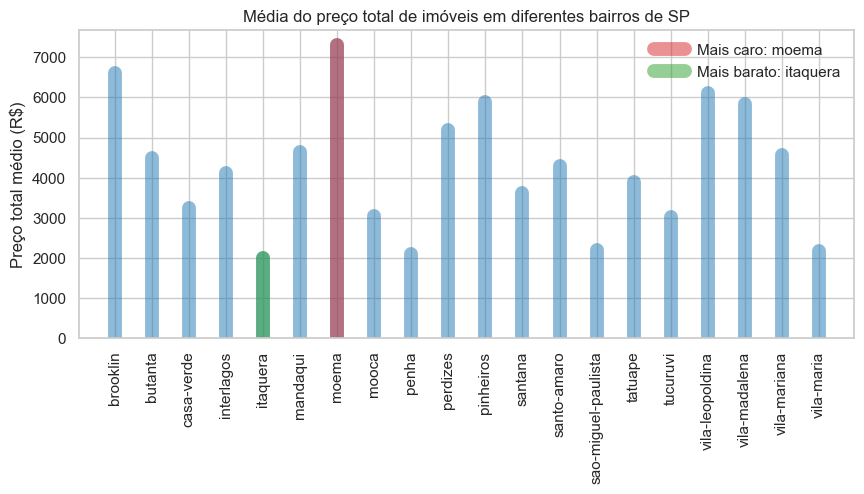

In [31]:
# bairro mais barato e bairro mais caro
avgs = []

fig, ax = plt.subplots(figsize=(10,4))
for n in range(len(bairros)):
    df_bairro = data_refined[data_refined['neighborhood']==bairros[n]]
    avg = df_bairro['Total'].mean()
    avgs.append(avg)
    ax.plot([n,n], [0,avg], color='tab:blue', lw=10, alpha=0.5)
idmax = np.argmax(avgs)
idmin = np.argmin(avgs)   
ax.plot([idmax,idmax], [0,max(avgs)], color='tab:red', lw=10, alpha=0.5, label=f'Mais caro: {bairros[idmax]}')
ax.plot([idmin,idmin], [0,min(avgs)], color='tab:green', lw=10, alpha=0.5, label=f'Mais barato: {bairros[idmin]}')
ax.set_xticks(range(20), bairros, rotation=90)
ax.set_ylabel('Preço total médio (R$)')
ax.set_ylim(bottom=0)
ax.legend(frameon=False)
ax.set_title('Média do preço total de imóveis em diferentes bairros de SP')
plt.show()

Moema é o bairro com maior valor médio total de gastos com imóveis, com gasto médio mensal superando os R$7k/mês.

* Qual bairro tem o maior alugel? Qual tem o menor? 

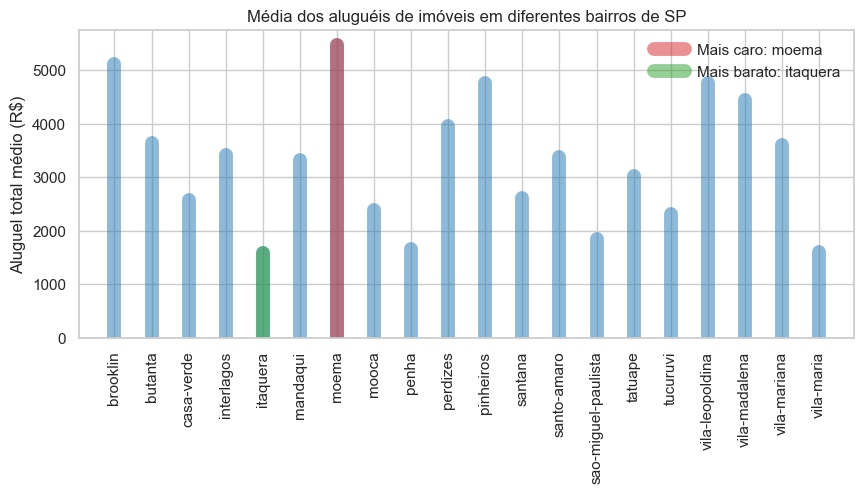

In [32]:
# bairro com maior aluguel
avgs = []
fig, ax = plt.subplots(figsize=(10,4))
for n in range(len(bairros)):
    df_bairro = data_refined[data_refined['neighborhood']==bairros[n]]
    avg = df_bairro['Aluguel'].mean()
    avgs.append(avg)
    ax.plot([n,n], [0,avg], color='tab:blue', lw=10, alpha=0.5)
idmax = np.argmax(avgs)
idmin = np.argmin(avgs)   
ax.plot([idmax,idmax], [0,max(avgs)], color='tab:red', lw=10, alpha=0.5, label=f'Mais caro: {bairros[idmax]}')
ax.plot([idmin,idmin], [0,min(avgs)], color='tab:green', lw=10, alpha=0.5, label=f'Mais barato: {bairros[idmin]}')
ax.set_xticks(range(20), bairros, rotation=90)
ax.set_ylabel('Aluguel total médio (R$)')
ax.set_ylim(bottom=0)
ax.set_title('Média dos aluguéis de imóveis em diferentes bairros de SP')
plt.legend(frameon=False)
plt.show()

Novamente, Moema lidera como o bairro com maior valor médio de aluguéis (média > R$5k/mês). Itaquera, por sua vez, é o local onde se paga, em média, mais barato pelo preço total do imóvel (incluindo aluguel mais taxas) e aluguel (excluindo taxas adicionais).

* Onde o condomínio é mais caro em média? 


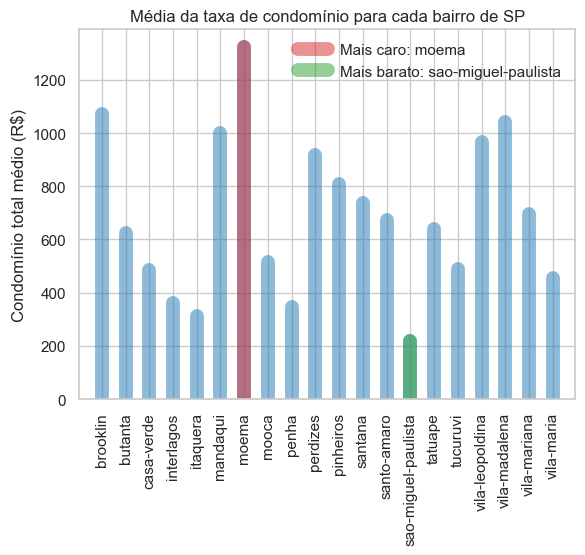

In [33]:
# Média da taxa de condomínio para cada bairro de SP
avgs = []
fig, ax = plt.subplots()
for n in range(len(bairros)):
    df_bairro = data_refined[data_refined['neighborhood']==bairros[n]]
    avg = df_bairro['Condomínio'].mean()
    avgs.append(avg)
    ax.plot([n,n], [0,avg], color='tab:blue', lw=10, alpha=0.5)
idmax = np.argmax(avgs)
idmin = np.argmin(avgs)   
ax.plot([idmax,idmax], [0,max(avgs)], color='tab:red', lw=10, alpha=0.5, label=f'Mais caro: {bairros[idmax]}')
ax.plot([idmin,idmin], [0,min(avgs)], color='tab:green', lw=10, alpha=0.5, label=f'Mais barato: {bairros[idmin]}')
ax.set_xticks(range(20), bairros, rotation=90)
ax.set_ylabel('Condomínio total médio (R$)')
ax.set_ylim(bottom=0)
ax.set_title('Média da taxa de condomínio para cada bairro de SP')
plt.legend(frameon=False)
plt.show()

Moema, pra variar, é o local onde se paga mais caro pelo condomínio, com média superando os R$1.2k/mê.s. São Miguel Paulista, por outro lado, é o local com menores taxas de condomínio em média 

* Onde a taxa de serviço é maior? onde é menor?

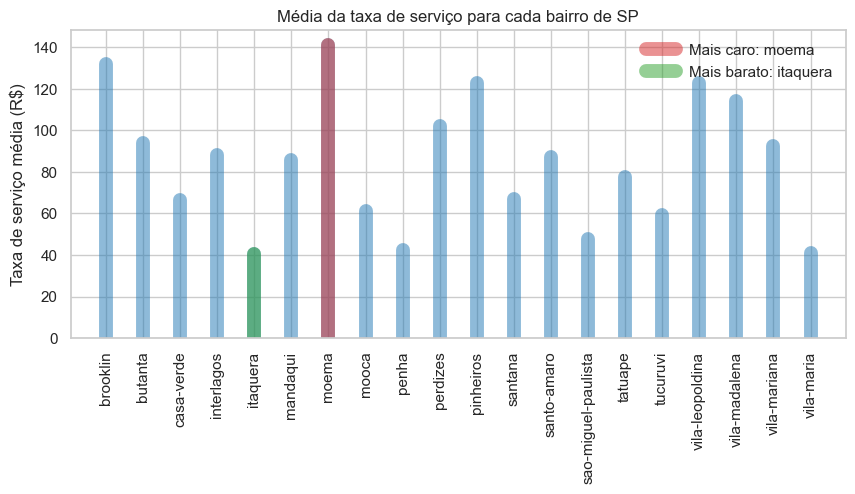

In [34]:
# Média da taxa de serviço para cada bairro de SP
avgs = []
fig, ax = plt.subplots(figsize=(10,4))
for n in range(len(bairros)):
    df_bairro = data_refined[data_refined['neighborhood']==bairros[n]]
    avg = df_bairro['Taxa de serviço'].mean()
    avgs.append(avg)
    ax.plot([n,n], [0,avg], color='tab:blue', lw=10, alpha=0.5)
idmax = np.argmax(avgs)
idmin = np.argmin(avgs)   
ax.plot([idmax,idmax], [0,max(avgs)], color='tab:red', lw=10, alpha=0.5, label=f'Mais caro: {bairros[idmax]}')
ax.plot([idmin,idmin], [0,min(avgs)], color='tab:green', lw=10, alpha=0.5, label=f'Mais barato: {bairros[idmin]}')
ax.set_xticks(range(20), bairros, rotation=90)
ax.set_ylabel('Taxa de serviço média (R$)')
ax.set_ylim(bottom=0)
ax.set_title('Média da taxa de serviço para cada bairro de SP')
plt.legend(frameon=False)
plt.show()

Novamente, Moema é o local onde mais se paga por serviços adicionais; Itaquera é onde paga-se menos. 

* Qual a oferta de locais com pelo menos uma vaga para carro?

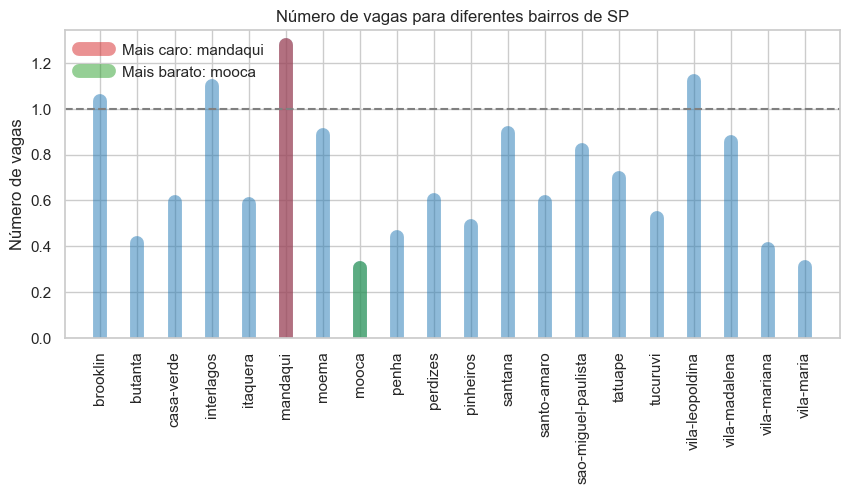

In [35]:
# Onde há maior oferta de vagas para automóvel?
avgs = []
fig, ax = plt.subplots(figsize=(10,4))
for n in range(len(bairros)):
    df_bairro = data_refined[data_refined['neighborhood']==bairros[n]]
    avg = df_bairro['vagas'].mean()
    avgs.append(avg)
    ax.plot([n,n], [0,avg], color='tab:blue', lw=10, alpha=0.5)
idmax = np.argmax(avgs)
idmin = np.argmin(avgs)   
ax.plot([idmax,idmax], [0,max(avgs)], color='tab:red', lw=10, alpha=0.5, label=f'Mais caro: {bairros[idmax]}')
ax.plot([idmin,idmin], [0,min(avgs)], color='tab:green', lw=10, alpha=0.5, label=f'Mais barato: {bairros[idmin]}')
ax.set_xticks(range(20), bairros, rotation=90)
ax.set_ylabel('Número de vagas')
ax.set_ylim(bottom=0)
ax.set_title('Número de vagas para diferentes bairros de SP')
ax.axhline(y=1, color='gray', ls='--')
plt.legend(frameon=False)
plt.show()

Se é vaga de garagem que você quer, então o Mandaqui é o lugar certo pra você! Esse é o bairro com maior oferta de locais com vaga, com mais de uma vaga (em média) por imóvel. 

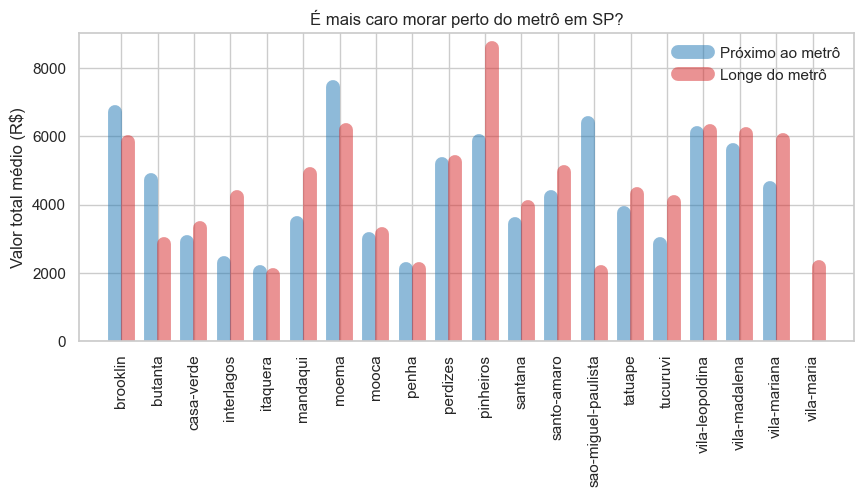

In [36]:
# morar perto do metro é mais caro?
com_metro, sem_metro = [], []

fig, ax = plt.subplots(figsize=(10,4))
for n in range(len(bairros)):

    df_com_metro = data_refined[(data_refined['neighborhood']==bairros[n]) & (data_refined['metro_proximo']==1)]
    df_sem_metro = data_refined[(data_refined['neighborhood']==bairros[n]) & (data_refined['metro_proximo']==0)]

    avg_com_metro = df_com_metro['Total'].mean()
    avg_sem_metro = df_sem_metro['Total'].mean()
    
    com_metro.append(avg_com_metro)
    sem_metro.append(avg_sem_metro)

    if n == 0:
        ax.plot([n-0.18,n-0.18], [0,avg_com_metro], color='tab:blue', lw=10, alpha=0.5, label='Próximo ao metrô')
        ax.plot([n+0.18,n+0.18], [0,avg_sem_metro], color='tab:red', lw=10, alpha=0.5, label ='Longe do metrô')
    else:
        ax.plot([n-0.18,n-0.18], [0,avg_com_metro], color='tab:blue', lw=10, alpha=0.5)
        ax.plot([n+0.18,n+0.18], [0,avg_sem_metro], color='tab:red', lw=10, alpha=0.5)

ax.set_xticks(range(20), bairros, rotation=90)
ax.set_ylabel('Valor total médio (R$)')
ax.set_ylim(bottom=0)
ax.set_title('É mais caro morar perto do metrô em SP?')
plt.legend(frameon=False)
plt.show()

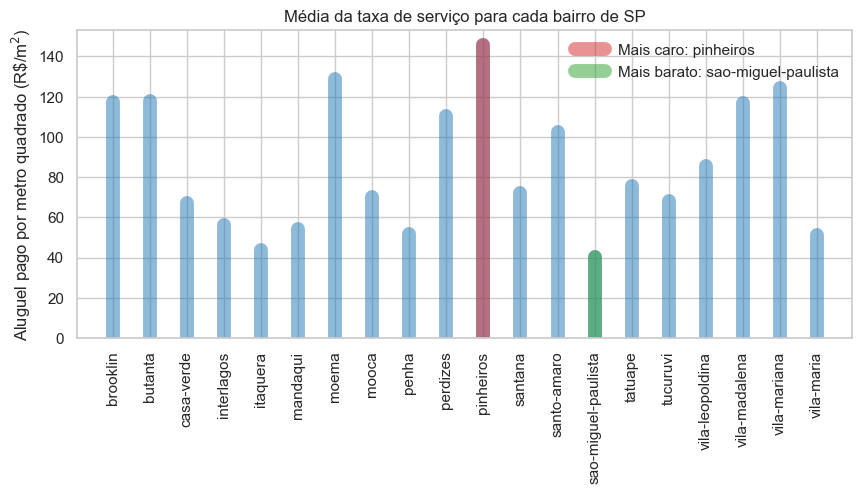

In [37]:
# Onde é mais caro o aluguel por metro quadrado em SP?
avgs = []
fig, ax = plt.subplots(figsize=(10,4))
for n in range(len(bairros)):
    df_bairro = data_refined[data_refined['neighborhood']==bairros[n]]
    avg = df_bairro['score'].mean()
    avgs.append(avg)
    ax.plot([n,n], [0,avg], color='tab:blue', lw=10, alpha=0.5)
idmax = np.argmax(avgs)
idmin = np.argmin(avgs)   
ax.plot([idmax,idmax], [0,max(avgs)], color='tab:red', lw=10, alpha=0.5, label=f'Mais caro: {bairros[idmax]}')
ax.plot([idmin,idmin], [0,min(avgs)], color='tab:green', lw=10, alpha=0.5, label=f'Mais barato: {bairros[idmin]}')
ax.set_xticks(range(20), bairros, rotation=90)
ax.set_ylabel(r'Aluguel pago por metro quadrado (R\$/m$^2$)')
ax.set_ylim(bottom=0)
ax.set_title('Média da taxa de serviço para cada bairro de SP')
plt.legend(frameon=False)
plt.show()

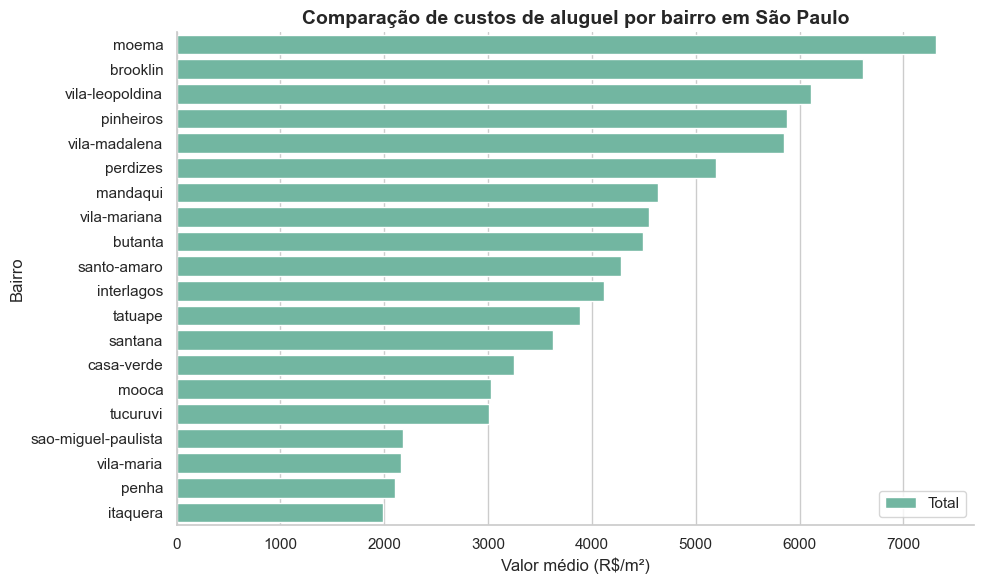

In [38]:
# Compute averages for each neighborhood and category
summary = (
    data_refined
    .groupby("neighborhood")[["Total"]]
    .mean()
    .reset_index()
)

# Rename columns for prettier plotting
summary = summary.rename(columns={
    "score": "Total"
})

# Melt into long format for seaborn
summary_long = summary.melt(id_vars="neighborhood",
                            value_vars="Total",
                            var_name="Categoria",
                            value_name="Valor")

# Order neighborhoods by total (descending)
order = summary.sort_values("Total", ascending=False)["neighborhood"]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary_long,
    x="Valor",
    y="neighborhood",
    hue="Categoria",
    order=order,
    palette="Set2"
)

plt.title("Comparação de custos de aluguel por bairro em São Paulo", fontsize=14, weight="bold")
plt.xlabel("Valor médio (R$/m²)")
plt.ylabel("Bairro")
plt.legend(title="")
sns.despine()
plt.tight_layout()
plt.show()


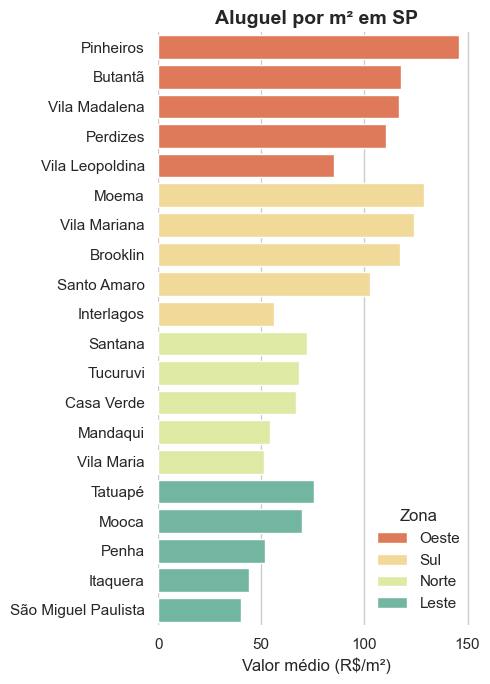

In [39]:
# --- Zone mapping (pt-BR) ---
zone_map = {
    'brooklin': 'Sul',
    'butanta': 'Oeste',
    'casa-verde': 'Norte',
    'interlagos': 'Sul',
    'itaquera': 'Leste',
    'mandaqui': 'Norte',
    'moema': 'Sul',
    'mooca': 'Leste',
    'penha': 'Leste',
    'perdizes': 'Oeste',
    'pinheiros': 'Oeste',
    'santana': 'Norte',
    'santo-amaro': 'Sul',
    'sao-miguel-paulista': 'Leste',
    'tatuape': 'Leste',
    'tucuruvi': 'Norte',
    'vila-leopoldina': 'Oeste',
    'vila-madalena': 'Oeste',
    'vila-mariana': 'Sul',
    'vila-maria': 'Norte'
}

# Pretty-name fixer
def pretty_name(raw):
    base = raw.replace('-', ' ').title()
    fixes = {
        'Butanta': 'Butantã',
        'Sao Miguel Paulista': 'São Miguel Paulista',
        'Tatuape': 'Tatuapé',
    }
    return fixes.get(base, base)

# Keep only your list (optional)
bairros = ['brooklin', 'butanta', 'casa-verde', 'interlagos', 'itaquera',
           'mandaqui', 'moema', 'mooca', 'penha', 'perdizes', 'pinheiros',
           'santana', 'santo-amaro', 'sao-miguel-paulista', 'tatuape',
           'tucuruvi', 'vila-leopoldina', 'vila-madalena', 'vila-mariana',
           'vila-maria']

# --- Build summary (Total = score) ---
summary = (
    data_refined[data_refined['neighborhood'].isin(bairros)]
    .groupby('neighborhood', as_index=False)['score']
    .mean()
)

summary['zona'] = summary['neighborhood'].map(zone_map)
summary['bairro'] = summary['neighborhood'].apply(pretty_name)

# --- Order zones by mean Total (desc = most expensive first) ---
zone_means = (summary.groupby('zona')['score'].mean()
              .sort_values(ascending=False))
zone_order = zone_means.index.tolist()  # e.g., ['Sul','Oeste','Norte','Leste'] sorted by price

# --- Order bairros: group by zone order, then sort within each zone by Total desc ---
ordered_labels = []
for z in zone_order:
    labs = (summary[summary['zona'] == z]
            .sort_values('score', ascending=False)['bairro']
            .tolist())
    ordered_labels.extend(labs)

summary['bairro'] = pd.Categorical(summary['bairro'],
                                   categories=ordered_labels, ordered=True)

# --- Nice 4-color palette for zones (consistent with zone_order) ---
palette_list = sns.color_palette("Spectral", n_colors=len(zone_order))
palette = {z: c for z, c in zip(zone_order, palette_list)}

# --- Plot ---
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(5, 7))

sns.barplot(
    data=summary,
    x='score', y='bairro',
    hue='zona', hue_order=zone_order,
    order=ordered_labels,
    dodge=False,  # single bar per neighborhood, colored by its zone
    palette=palette,
    ax=ax
)

# Labels & title
ax.set_xlabel("Valor médio (R$/m²)")
ax.set_ylabel("")
ax.set_title("Aluguel por m² em SP", fontsize=14, weight='bold')

# Legend
leg = ax.legend(title="Zona", frameon=False, loc="lower right")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


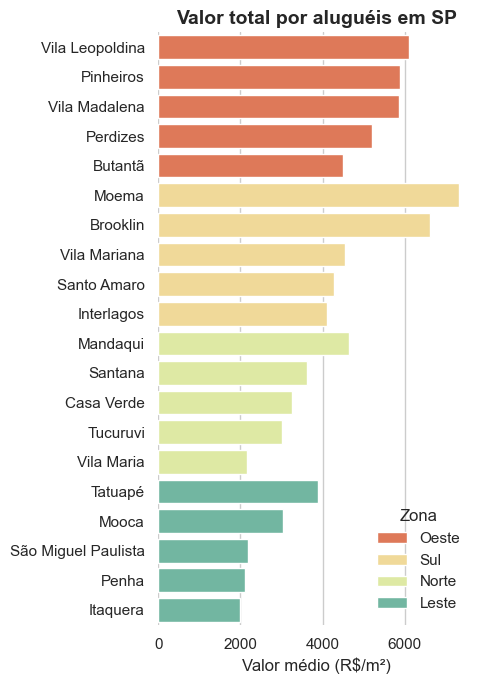

In [40]:
# --- total
summary = (
    data_refined[data_refined['neighborhood'].isin(bairros)]
    .groupby('neighborhood', as_index=False)['Total']
    .mean()
)

summary['zona'] = summary['neighborhood'].map(zone_map)
summary['bairro'] = summary['neighborhood'].apply(pretty_name)

# --- Order zones by mean Total (desc = most expensive first) ---
zone_means = (summary.groupby('zona')['Total'].mean()
              .sort_values(ascending=False))
zone_order = zone_means.index.tolist()  # e.g., ['Sul','Oeste','Norte','Leste'] sorted by price

# --- Order bairros: group by zone order, then sort within each zone by Total desc ---
ordered_labels = []
for z in zone_order:
    labs = (summary[summary['zona'] == z]
            .sort_values('Total', ascending=False)['bairro']
            .tolist())
    ordered_labels.extend(labs)

summary['bairro'] = pd.Categorical(summary['bairro'],
                                   categories=ordered_labels, ordered=True)

# --- Nice 4-color palette for zones (consistent with zone_order) ---
palette_list = sns.color_palette("Spectral", n_colors=len(zone_order))
palette = {z: c for z, c in zip(zone_order, palette_list)}

# --- Plot ---
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(5, 7))

sns.barplot(
    data=summary,
    x='Total', y='bairro',
    hue='zona', hue_order=zone_order,
    order=ordered_labels,
    dodge=False,  # single bar per neighborhood, colored by its zone
    palette=palette,
    ax=ax
)

# Labels & title
ax.set_xlabel("Valor médio (R$/m²)")
ax.set_ylabel("")
ax.set_title("Valor total por aluguéis em SP", fontsize=14, weight='bold')

# Legend
leg = ax.legend(title="Zona", frameon=False, loc="lower right")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


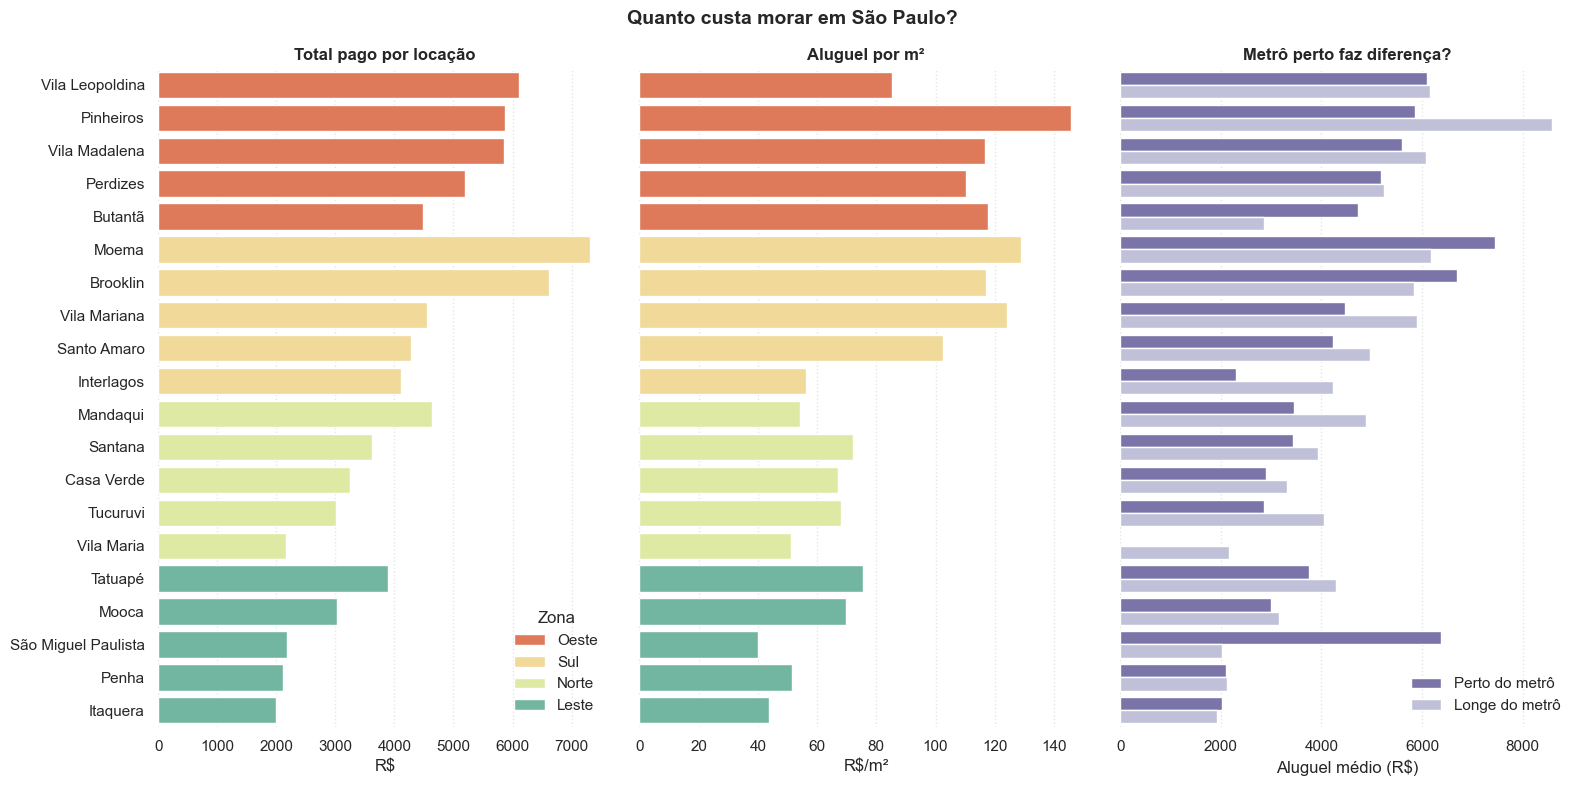

In [41]:
# --- Base frame with zone + pretty names ---
base = pd.DataFrame({'neighborhood': bairros})
base['zona'] = base['neighborhood'].map(zone_map)
base['bairro'] = base['neighborhood'].apply(pretty_name)

# =========================
# Aggregations
# =========================

# Left: score mean
score_summary = (
    data_refined[data_refined['neighborhood'].isin(bairros)]
    .groupby('neighborhood', as_index=False)['score'].mean()
    .merge(base, on='neighborhood', how='right')
)

# Center: Total mean (assumes data_refined['Total'] exists)
total_summary = (
    data_refined[data_refined['neighborhood'].isin(bairros)]
    .groupby('neighborhood', as_index=False)['Total'].mean()
    .merge(base, on='neighborhood', how='right')
)

# Right: Total mean split by metro proximity
metro_summary = (
    data_refined[data_refined['neighborhood'].isin(bairros)]
    .groupby(['neighborhood', 'metro_proximo'], as_index=False)['Total'].mean()
    .merge(base, on='neighborhood', how='right')
)

# Map metro flag to labels
metro_summary['Metrô'] = metro_summary['metro_proximo'].map({1: 'Perto do metrô', 0: 'Longe do metrô'})

# =========================
# Ordering (by zone mean Total desc; within zone by Total desc)
# =========================

zone_means = (total_summary.groupby('zona')['Total'].mean()
              .sort_values(ascending=False))
zone_order = zone_means.index.tolist()  # e.g. ['Sul','Oeste','Norte','Leste'] sorted by price

ordered_labels = []
for z in zone_order:
    labs = (total_summary[total_summary['zona'] == z]
            .sort_values('Total', ascending=False)['bairro']
            .tolist())
    ordered_labels.extend(labs)

for df, ycol in [(score_summary, 'bairro'),
                 (total_summary, 'bairro'),
                 (metro_summary, 'bairro')]:
    df[ycol] = pd.Categorical(df[ycol], categories=ordered_labels, ordered=True)

# =========================
# Palettes
# =========================

zone_colors = sns.color_palette("Spectral", n_colors=len(zone_order))
zone_palette = {z:c for z, c in zip(zone_order, zone_colors)}
metro_palette = {'Perto do metrô': sns.color_palette("tab20c")[-8],
                 'Longe do metrô': sns.color_palette("tab20c")[-6]}

# =========================
# Plot row (3 subplots)
# =========================

fig, axes = plt.subplots(ncols=3, figsize=(16, 8), sharey=True)

# --- Left: score ---
sns.barplot(
    data=total_summary,
    x='Total', y='bairro',
    hue='zona', hue_order=zone_order,
    order=ordered_labels,
    dodge=False, palette=zone_palette,
    ax=axes[0]
)
axes[0].set_title("Total pago por locação", fontsize=12, weight='bold')
axes[0].set_xlabel("R$")
axes[0].set_ylabel("")
axes[0].legend(title="Zona", frameon=False, loc="lower right")

# --- Center: Total ---
sns.barplot(
    data=score_summary,
    x='score', y='bairro',
    hue='zona', hue_order=zone_order,
    order=ordered_labels,
    dodge=False, palette=zone_palette,
    ax=axes[1]
)
axes[1].set_title("Aluguel por m²", fontsize=12, weight='bold')
axes[1].set_xlabel("R$/m²")
axes[1].set_ylabel("")
axes[1].legend([],[], frameon=False)  # hide duplicate legend

# --- Right: Total vs Metrô ---
sns.barplot(
    data=metro_summary,
    x='Total', y='bairro',
    hue='Metrô', hue_order=['Perto do metrô', 'Longe do metrô'],
    order=ordered_labels,
    dodge=True, palette=metro_palette,
    ax=axes[2]
)
axes[2].set_title("Metrô perto faz diferença?", fontsize=12, weight='bold')
axes[2].set_xlabel("Aluguel médio (R$)")
axes[2].set_ylabel("")
axes[2].legend(title="", frameon=False, loc="lower right")

# Aesthetics
for ax in axes:
    ax.grid(axis='x', linestyle=':', alpha=0.5)
    sns.despine(ax=ax, left=True, bottom=True)

fig.suptitle("Quanto custa morar em São Paulo?", y=0.98,
             fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


Em linhas gerais, não há tanta diferença no preço pago por morar perto ou longe do metrô. Rigorosamente falando, há, na verdade, uma leve tendência de preços mais altos para imóveis afastados do metrô.

Mas, de maneira geral, esses dados já nos permitem observar algumas tendências:
* Moema é, disparado, o local mais caro de se morar em SP. Não é todo lugar que oferece vaga por lá e morar perto do metrô é consideravalmente mais caro. Portanto, se você quer economizar, não vá para lá.
* Pinheiro não fica muito atrás - de fato, o aluguel pago por metro quadrado é mais caro lá do que em Moema.
* Quer economia? Itaquera é o seu lugar - menor preço médio de aluguel e condomínio, morar perto do metrô é quase o mesmo preço que morar longe. Mas, se você precisa de vaga de garagem, morar lá pode ser um problema - em média, pouco mais da métade do imóveis oferecem vaga de garagem. 


In [42]:
data_refined.to_csv(r'D:\Tech-Challenge-QuintoAndar\database\data_refined', index=False)